In [ ]:
import pickle
import IPython
import os
from matplotlib import pyplot
import librosa
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
import pickle
import IPython
import os
from matplotlib import pyplot
import numpy as np
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/DeepLearning')

In [ ]:
tf.random.set_seed(999)
np.random.seed(999)

In [ ]:
with open('denoise_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

with open('data_11k.pickle' ,'rb') as g:
    data_11k = pickle.load(g)

with open('data_5k.pickle' ,'rb') as g:
    data_5k = pickle.load(g)

Downsample the data

In [ ]:
from librosa import resample
# clean data downsampled to 5k
data_5k = librosa.resample(data[0], 11000, 5500, res_type='kaiser_best', fix=True, scale=False)


In [ ]:
#Saving the downsampled data as a pickle file
pick_insert = open('/content/drive/MyDrive/DeepLearning/data_5k.pickle','wb')
pickle.dump(data_5k, pick_insert)
pick_insert.close()

Spectogram

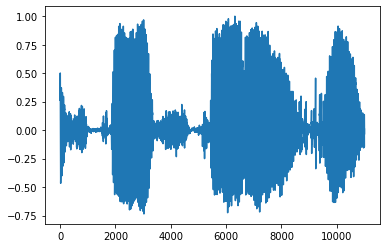

In [ ]:
data_5k.shape
data_11k.shape

%matplotlib inline 
pyplot.plot(data[0][0]);
cdata = data[0]

(9600, 11000)
(11000,)


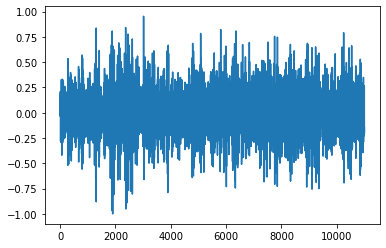

In [ ]:
ndata = data_11k
for i in range(len(ndata)):
  ndata[i] /= np.max(np.abs(ndata[i]),axis=0)

print(ndata.shape)
print(ndata[1].shape)

pyplot.plot(ndata[0]);
#pyplot.plot(data_5k[0]);

FFT

In [ ]:
fft_clean = np.fft.fft(data_5k[0])
magnitude_clean = np.abs(fft_clean)
frequency_clean = np.linspace(0,11000, len(magnitude_clean))

fft_noise = np.fft.fft(ndata)
magnitude_noise = np.abs(fft_noise)
frequency_noise = np.linspace(0,11000, len(magnitude_noise))

Text(0.5, 0, 'Frequency (Hz)')

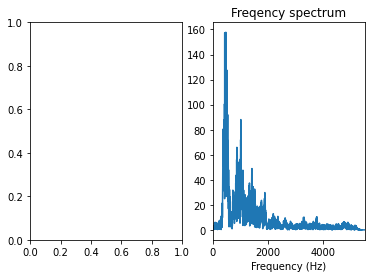

In [ ]:
%matplotlib inline 
fig, ax = pyplot.subplots(ncols = 2)

pyplot.plot(frequency_clean, magnitude_clean)
pyplot.xlim(0,5500)
pyplot.title('Freqency spectrum');

pyplot.xlabel('Frequency (Hz)')

Train/Test Split

In [ ]:
clean_sounds_list = []
noisy_sounds_list = []

for i in tqdm(cdata[1:]):
  clean_sounds_list = tf.concat((clean_sounds_list,i),0)

for i in tqdm(ndata[1:]):
  noisy_sounds_list = tf.concat((noisy_sounds_list,i),0)

clean_sounds_list.shape,noisy_sounds_list.shape


  0%|          | 0/9599 [00:00<?, ?it/s]

  0%|          | 0/9599 [00:00<?, ?it/s]

(TensorShape([105589000]), TensorShape([105589000]))

In [ ]:
clean_sounds_list = tf.expand_dims(clean_sounds_list, -1)
noisy_sounds_list = tf.expand_dims(noisy_sounds_list, -1)

In [ ]:
batching_size = 12000

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape,noisy_train.shape

  0%|          | 0/8799 [00:00<?, ?it/s]

(TensorShape([8799, 12000, 1]), TensorShape([8799, 12000, 1]))

Train/test split

In [ ]:
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
  return dataset

In [ ]:
#total = 8799, 20% = 1759, 80% = 7040
train_dataset = get_dataset(noisy_train[:7040],clean_train[:7040])
test_dataset = get_dataset(noisy_train[7040:],clean_train[7040:])

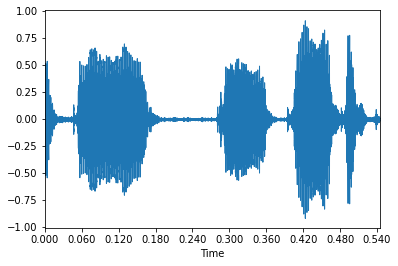

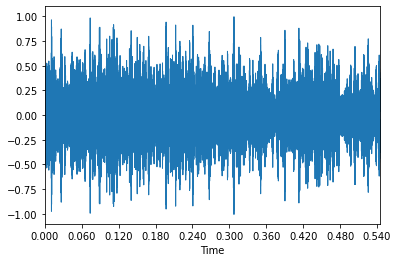

In [ ]:
librosa.display.waveplot(np.squeeze(clean_train[5].numpy(),axis=-1))
plt.show()
librosa.display.waveplot(np.squeeze(noisy_train[5].numpy(),axis=-1))
plt.show()

Creating the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
inp = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 6000, 2)      66          ['input_8[0][0]']                
                                                                                                  
 conv1d_41 (Conv1D)             (None, 3000, 4)      260         ['conv1d_40[0][0]']              
                                                                                                  
 conv1d_42 (Conv1D)             (None, 1500, 8)      1032        ['conv1d_41[0][0]']              
                                                                                            

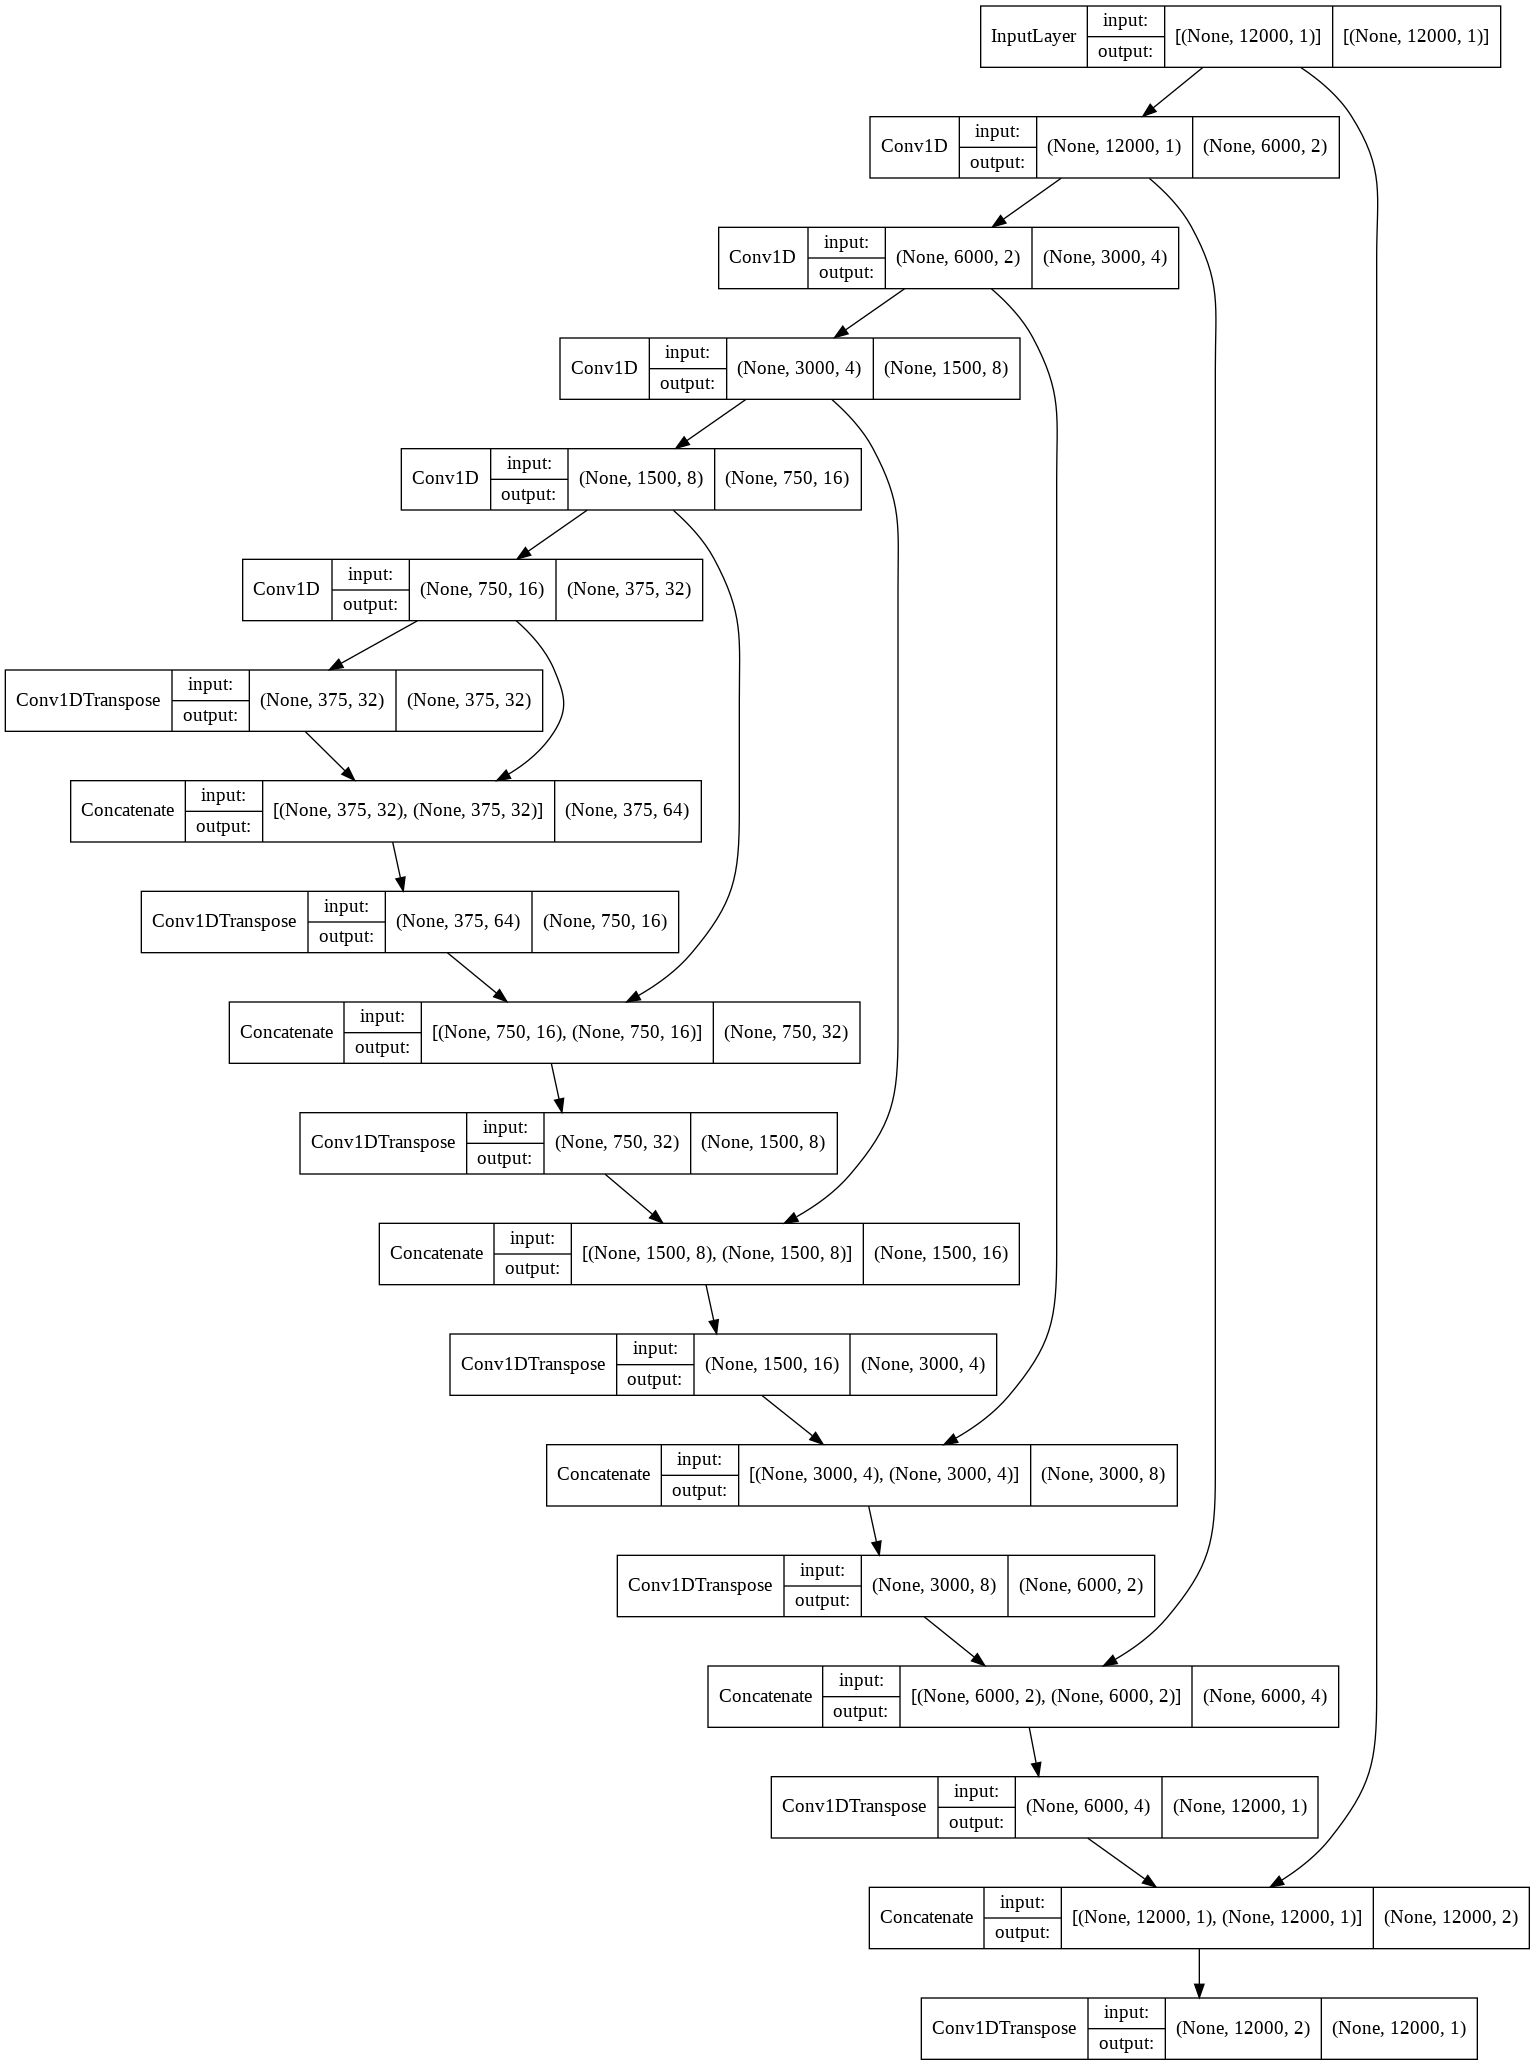

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_dataset,epochs=20)

Epoch 1/20
110/110 [==============================] - 5s 33ms/step - loss: 0.0885
Epoch 2/20
110/110 [==============================] - 4s 32ms/step - loss: 0.0594
Epoch 3/20
110/110 [==============================] - 4s 32ms/step - loss: 0.0577
Epoch 4/20
110/110 [==============================] - 4s 33ms/step - loss: 0.0557
Epoch 5/20
110/110 [==============================] - 4s 33ms/step - loss: 0.0545
Epoch 6/20
110/110 [==============================] - 4s 33ms/step - loss: 0.0531
Epoch 7/20
110/110 [==============================] - 4s 33ms/step - loss: 0.0522
Epoch 8/20
110/110 [==============================] - 4s 33ms/step - loss: 0.0517
Epoch 9/20
110/110 [==============================] - 4s 33ms/step - loss: 0.0513
Epoch 10/20
110/110 [==============================] - 4s 33ms/step - loss: 0.0509
Epoch 11/20
110/110 [==============================] - 4s 33ms/step - loss: 0.0506
Epoch 12/20
110/110 [==============================] - 4s 33ms/step - loss: 0.0503
Epoch 13/20
1

Checking audio samples

In [ ]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[30].numpy()),rate=11000)

In [ ]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[30],-1),0))),rate=11000)

In [ ]:
model.save('NoiseSuppressionModel2.h5')

In [ ]:
model.evaluate(test_dataset)

27/27 [==============================] - 1s 21ms/step - loss: 0.0494


0.04937126487493515

In [104]:
%%timeit
tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[30],-1),0)))

10 loops, best of 5: 38.4 ms per loop


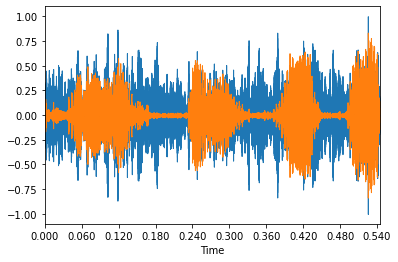

In [113]:
librosa.display.waveplot(np.squeeze(tf.expand_dims(noisy_train[30],-1)))
librosa.display.waveplot( np.array(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[30],-1),0)))) )

In [114]:

def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, me/sd)

print(np.mean(signaltonoise(noisy_train[30])))

0.0003574537
